In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Exercise 1
First we define the functions for generating the grid (taking into account the value at the cell center), then generating an initial condition in the density grid and the iterating step for advancing the density profile in time. 

In [2]:


def make_grid(N,interval):
    dx = (interval[1]-interval[0])/N
    cell_center = np.linspace(interval[0],interval[1]-dx,N)
    cell_center = cell_center + dx/2.
    
    return dx,cell_center

def initial_condition(x,x_split,values):
    density = np.array([values[0] if x[i]<= x_split else values[1] for i in range(len(x)) ])
    return density

def advance_step(density,vel,dx,dt):
        
    
    grid_dens = np.zeros(len(density)+2)

    grid_dens[1:-1] = density[:]
    grid_dens[0] = grid_dens[1]
    grid_dens[-1] = grid_dens[-2]
    

    new_dens = np.array([ grid_dens[i]-(dt/dx)*(vel/2)*(grid_dens[i-1] - grid_dens[i+1]) for i in range(1,len(grid_dens)-1) ])

    return new_dens

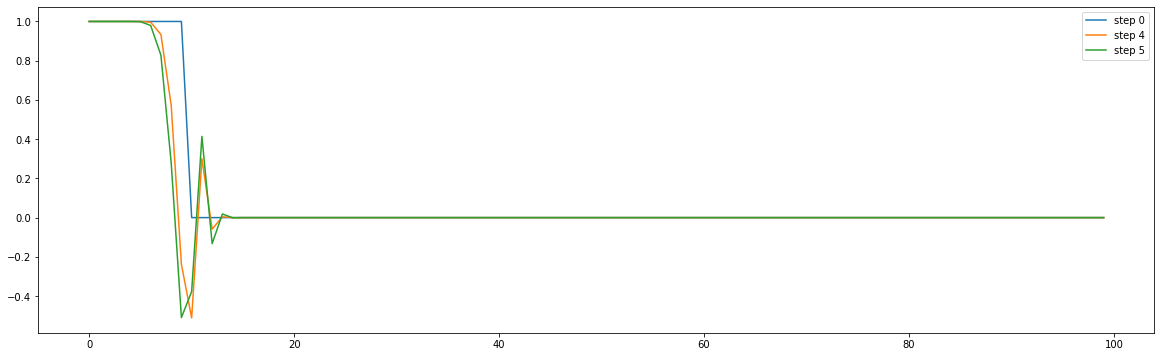

In [3]:
# X between 0 and 100 divided id 100 steps 
dx,grid = make_grid(100,[0,100])
#inital condition n = 0
dens = initial_condition(grid,10,[1,0])

# parameters
vel = 5 #velocity c
n_iter = 5 # numberofinterations (until n = 5)
dt = 0.1 #  time step

all_dens = np.zeros([n_iter+1,len(dens)]) #array to store density array for every iteration
all_dens[0,:] = dens # initial condition in n = 0

for i in range(1,n_iter+1):
    # advance step n_iter times
    all_dens[i,:] = advance_step(all_dens[i-1,:],vel,dx,dt)

# selected iterations to plot  
plotiters = [0,4,5]

x = np.arange(len(dens))*dx
plt.figure(figsize=(20,6))
for elem in plotiters:
    plt.plot(x,all_dens[elem,:], label = "step {}".format(elem))
plt.legend()

The center scheme at first order do NOT obey the maximum principle, causing thevalue to diverge at the boundary of the different density regions. This scheme does not satisfy the conditions to evolve such a scenartio in time. This scheme might seem like a naive approximation for a discontinous initial condition.

Now, the advance in time will be given by the Lax-Wendroff method implemented below.

In [4]:
def advance_step_LF(density,vel,dx,dt):
        
    grid_dens = np.zeros(len(density)+2)

    grid_dens[1:-1] = density[:]
    grid_dens[0] = grid_dens[1]
    grid_dens[-1] = grid_dens[-2]
    

    new_dens = np.array([ (grid_dens[i-1]+grid_dens[i+1])-(dt/dx)*vel*(grid_dens[i-1] - grid_dens[i+1]) for i in range(1,len(grid_dens)-1) ])
    new_dens = new_dens*0.5
    return new_dens

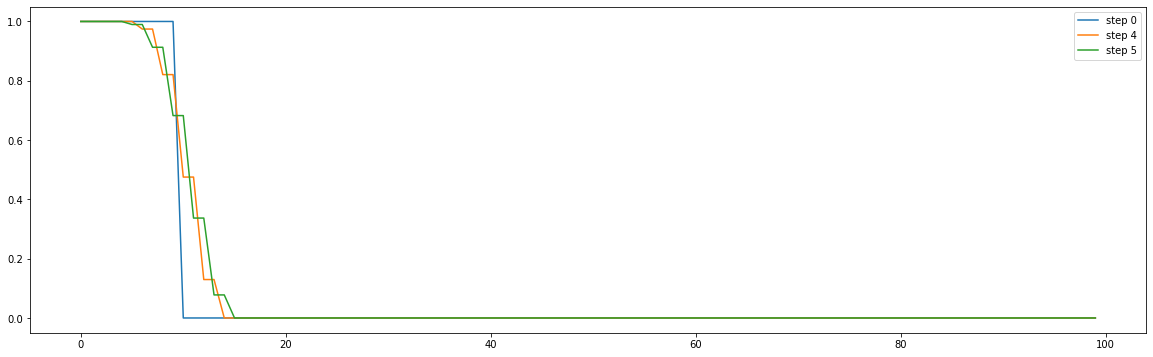

In [5]:
dx,grid = make_grid(100,[0,100])
dens = initial_condition(grid,10,[1,0])

vel = -2
n_iter = 5
coef = 0.05
dt = 0.1

all_dens = np.zeros([n_iter+1,len(dens)])
all_dens[0,:] = dens

for i in range(1,n_iter+1):
    all_dens[i,:] = advance_step_LF(all_dens[i-1,:],vel,dx,dt)

    
plotiters = [0,4,5]
x = np.arange(len(dens))*dx
plt.figure(figsize=(20,6))
for elem in plotiters:
    plt.plot(x,all_dens[elem,:], label = "step {}".format(elem))
plt.legend()

The Lax-Wendroff method has a much better performance in this conditions and does not show divergence in the values around the boundary. 

## Exercise 2
For performing the von Neumann stability analysis, waves of the form $e^{ikx}$ are evaluated within the advection case where $\partial_t U(x,t) + \partial_x ( c U(x,t) ) = 0$ for timesteps up to $n = 40$ using different values of $\Delta t$. To evaluate the stability of the algorithm (and vanishing of the density)for every $\Delta t$ chosen, the max value of the wave (amplitude) at selected iterations are contrasted with the amplitude of the initial condition. the value *k* is selected at random but as we will see the stability condition holds even for low spatial definition of the wave. 

A proposed adimensional key value to trace, refered as the stability parameter $S_p = |c \frac{\Delta t}{\Delta x}|$ , is displayed for every $\Delta t$. This value might encode the stability conditions given that the magnitude of the update at every point depends on this value. 

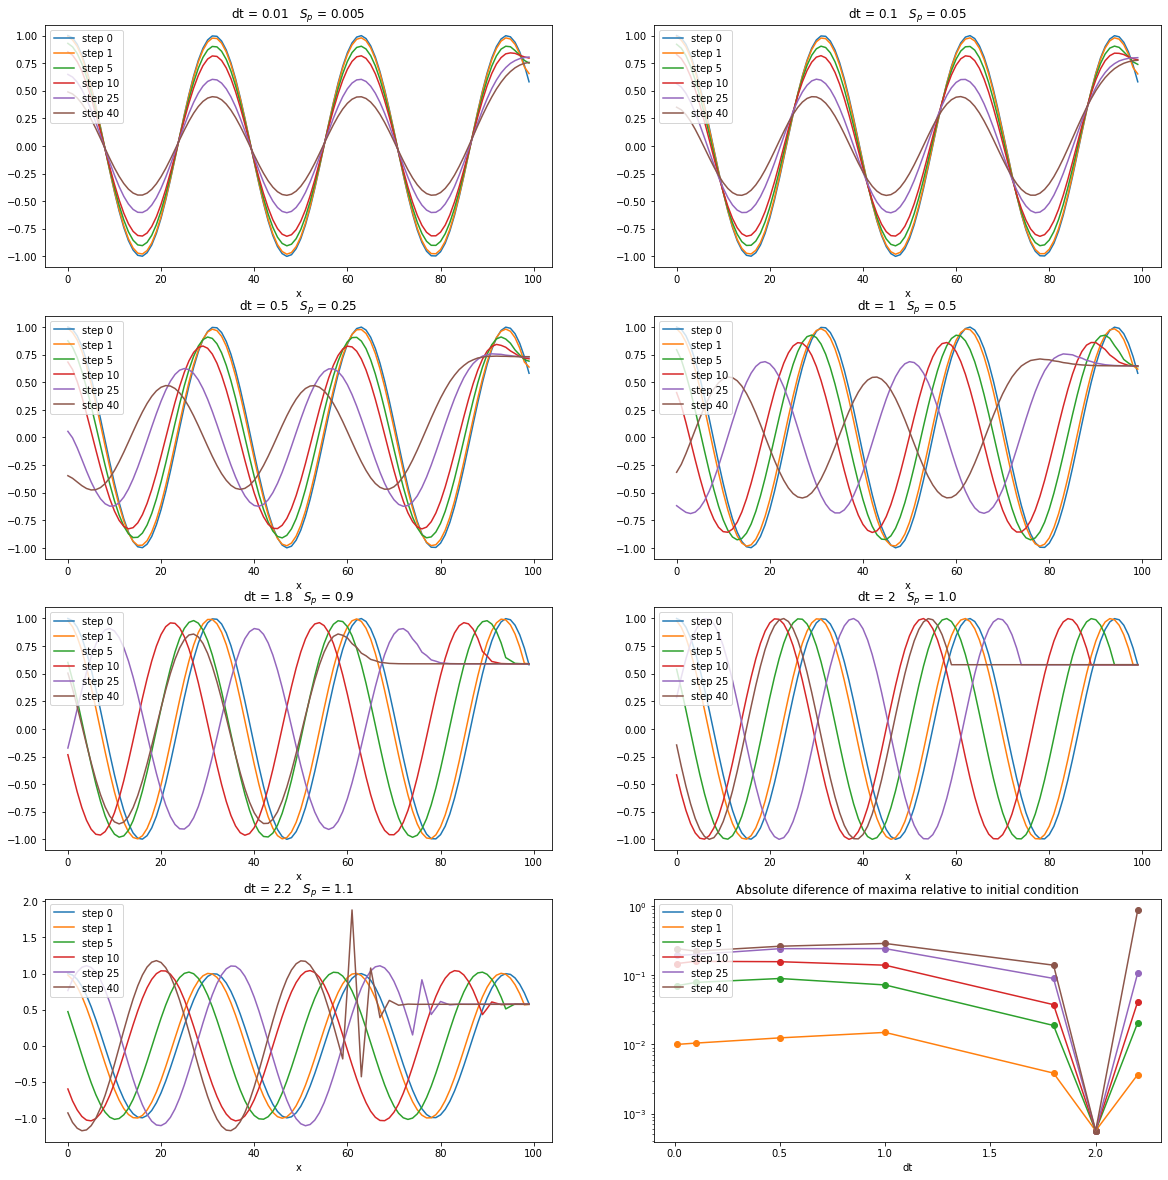

In [10]:
dx,grid = make_grid(100,[0,100])
dt_essay = [0.01,0.1,0.5,1,1.8,2,2.2]
plotiters = [0,1,5,10,25,40]
k = 0.2
vel = 0.5
n_iter = 40


plt.figure(figsize=(20,len(dt_essay)*6))
maxdifs = np.zeros([len(dt_essay),len(plotiters)])
MSE = []
for i in range(len(dt_essay)):
    dt=dt_essay[i]
    sp = vel*dt/dx # stability param
    dens = np.array([np.exp(1j*k*m) for m in range(len(grid))])
    all_dens = np.zeros([n_iter+1,len(dens)])
    all_dens[0,:] = dens

    for j in range(1,n_iter+1):
        all_dens[j,:] = advance_step_LF(all_dens[j-1,:],vel,dx,dt)
        if(j in plotiters):
            pos = np.where(np.array(plotiters)==j)[0][0]
            maxdifs[i,pos] = abs(np.max(all_dens[0,:])-np.max(all_dens[j,:]))

  
    x = np.arange(len(dens))*dx
    plt.subplot(len(dt_essay)+1,2,i+1)
    plt.title("dt = {}   $S_p$ = {}".format(dt,sp))
    plt.xlabel("x")
    for elem in plotiters:
        plt.plot(x,all_dens[elem,:], label = "step {}".format(elem))
    
    plt.legend(loc=2)
plt.subplot(len(dt_essay)+1,2,len(dt_essay)+1)
plt.xlabel("dt")
plt.title("Absolute diference of maxima relative to initial condition")
for i in range(len(plotiters)):
    plt.plot(dt_essay,maxdifs[:,i],label = "step {}".format(plotiters[i]))
    plt.scatter(dt_essay,maxdifs[:,i])
plt.yscale("log")
plt.legend(loc=2)
#plt.xscale("log")

It jumps to sight that with *time* the (real part of the) waves shrink for values of $S_p < 1$ and that for values   of $S_p > 1$ the xaves star to diverge around discontinuities. For the value of $S_p = 1$ the amplitude remains constant, since replacing this value in the LF method implies that $U_i^{n+1} = U_{i+1}^{n} $ for positive values of c and $U_i^{n+1} = U_{i-1}^{n} $ for the negative values. 

Given this, anaive hypothesis on the stability conditions for the parameters is:
$$S_p = |c \frac{\Delta t}{\Delta x}| < 1$$

## Exercise 3

In [ ]:
# X between 0 and 100 divided id 100 steps 
dx,grid = make_grid(100,[1,10])
#inital condition n = 0
dens = initial_condition(grid,5,[1/2,0])

# parameters
vel = 5 #velocity c
n_iter = 5 # numberofinterations (until n = 5)
dt = 0.1 #  time step

all_dens = np.zeros([n_iter+1,len(dens)]) #array to store density array for every iteration
all_dens[0,:] = dens # initial condition in n = 0

for i in range(1,n_iter+1):
    # advance step n_iter times
    all_dens[i,:] = advance_step(all_dens[i-1,:],vel,dx,dt)

# selected iterations to plot  
plotiters = [0,4,5]

x = np.arange(len(dens))*dx
plt.figure(figsize=(20,6))
for elem in plotiters:
    plt.plot(x,all_dens[elem,:], label = "step {}".format(elem))
plt.legend()